# Анализ оттока клиентов в банке

Проанализируем клиентов регионального банка и выделим сегменты клиентов, которые склонны уходить из банка. 

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Презентация - https://disk.yandex.ru/i/YcSz60vYY7E_tw

Описание столбцов:
- `USERID` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `city` — город,
- `gender` — пол,
- `age` — возраст,
- `equity` — количество баллов собственности
- `balance` — баланс на счёте,
- `products` — количество продуктов, которыми пользуется клиент,
- `credit_card` — есть ли кредитная карта,
- `last_activity` — активный клиент,
- `EST_SALARY` — оценочный доход клиента,
- `сhurn` — признак оттока.

## Загрузка данных

Импортируем библиотеки и откроем файл с данными.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/bank_scrooge.csv')
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Посмотрим основную информацию о данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Названия двух столбцов указаны в верхнем регистре, в данных есть пропуски. У столбца age тип данных float.

## Предобработка данных

Здесь исправим типы данных, проверим пропуски и дубликаты и обработаем их.

Сначала приведем названия столбцов к нижнему регистру.

In [4]:
data.columns = data.columns.str.lower()
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

Теперь проверим дубликаты.

In [5]:
print(f'Полных дубликатов - {data.duplicated().sum()}')
print(f'Дубликатов по столбцу userid - {data["userid"].duplicated().sum()}')
print(f'Дубликатов по столбцам userid и city - {data[["userid", "city"]].duplicated().sum()}')

Полных дубликатов - 0
Дубликатов по столбцу userid - 73
Дубликатов по столбцам userid и city - 0


Полных дубликатов нет. Есть дубликаты по столбцу userid, однако дубликатов по столбцам userid и city нет. В одном городе нет людей с одинаковыми userid.

Теперь перейдем к пропускам. У нас есть пропуски в столбцах balance и age. Проверим корреляцию этих столбцов другими.

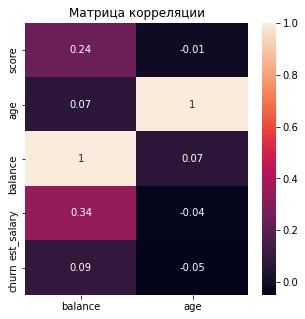

In [6]:
plt.figure(figsize=(5,5))
sns.heatmap(round(data[['score', 'age', 'balance', 'est_salary', 'churn']].corr()[['balance', 'age']], 2), annot=True)
plt.title('Матрица корреляции')
plt.show()

In [7]:
print(f'Процент пропусков в столбце balance - {data["balance"].isna().mean() * 100}%')
print(f'Процент пропусков в столбце age - {data["age"].isna().mean() * 100}%')

Процент пропусков в столбце balance - 22.95%
Процент пропусков в столбце age - 0.26%


У столбцов balance и age нет высокой корреляции с другими столбцами. Заполнить пропуски по другим данным не получится. Удалим пропуски в столбце age, их очень мало. Пропуски в столбце balance трогать не будем.

In [8]:
data = data.dropna(subset=['age'])
data['age'] = data['age'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         9974 non-null   int64  
 1   score          9974 non-null   float64
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 1013.0+ KB


Привели названия столбцов к нижнему регистру, проверили дубликаты, заполнили пропуски и изменили тип данных столбца age на int.

## Исследовательский анализ данных

Посмотрим на распределения данных и на распределение данных в разрезе оттока. Для этого напишем функции для визуализации числовых и не числовых столбцов.

In [9]:
def plot_distribution_numeric(data, column):
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    sns.boxplot(y=data[column], ax=ax1)
    plt.title(f'Распределение {column}')
    plt.xlabel('')
    plt.ylabel(column)
    ax2 = plt.subplot(1,2,2)
    sns.histplot(data, hue='churn', x=column, stat='density', common_norm=False, ax=ax2)
    plt.title(f'Распределение частоты {column} по оттоку')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    
def plot_distribution_object(data, column):
    plt.figure(figsize=(15,5))
    sns.histplot(data, hue='churn', x=column, discrete=True, stat='density', common_norm=False)
    plt.title(f'Распределение частоты {column} по оттоку')
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()

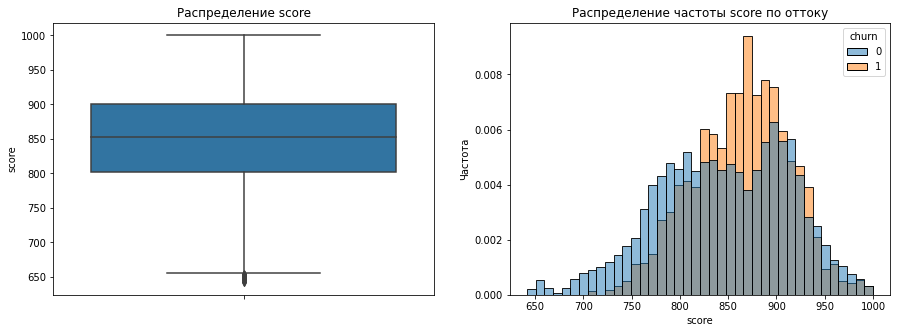

In [10]:
plot_distribution_numeric(data, 'score')

Больше всего клиентов с 800-900 баллами кредитного рейтинга. Наибольший отток клиентов с 830-940 баллами.

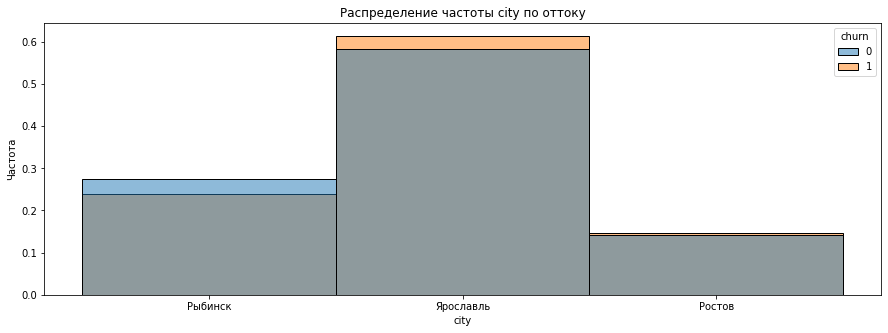

In [11]:
plot_distribution_object(data, 'city')

Больше всего клиентов из Ярославля. В рыбинске наименьшая отточность, в Ярославле наибольшая. Разница между городами не большая.

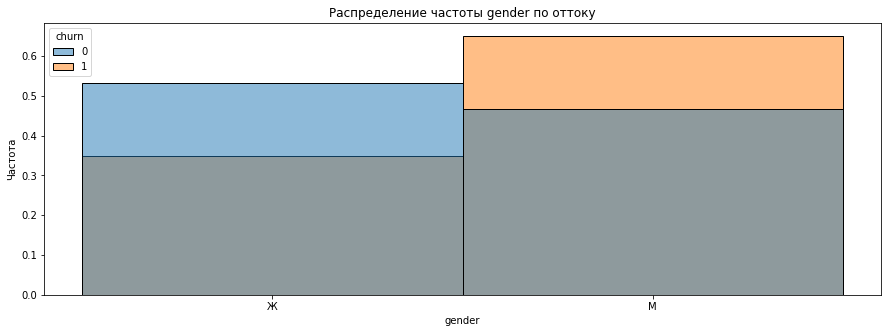

In [12]:
plot_distribution_object(data, 'gender')

Мужчин и женщин примерно одинаково. Наибольшая отточность у мужчин.

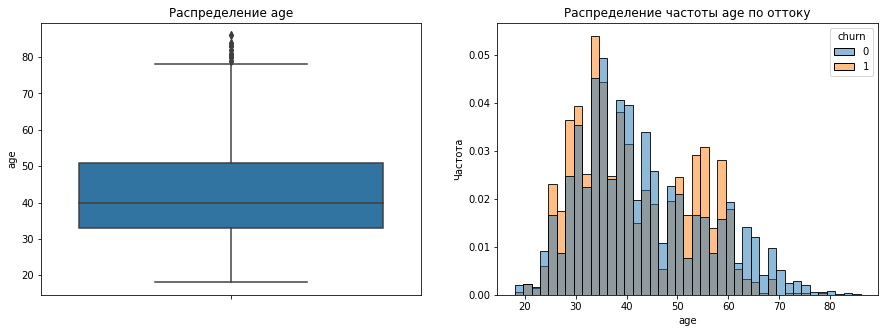

In [13]:
plot_distribution_numeric(data, 'age')

Больше всего клиентов возрастом от 30 до 50 лет. Наибольшая отточность у 25-35-ти летних и у 50-59-ти летних.

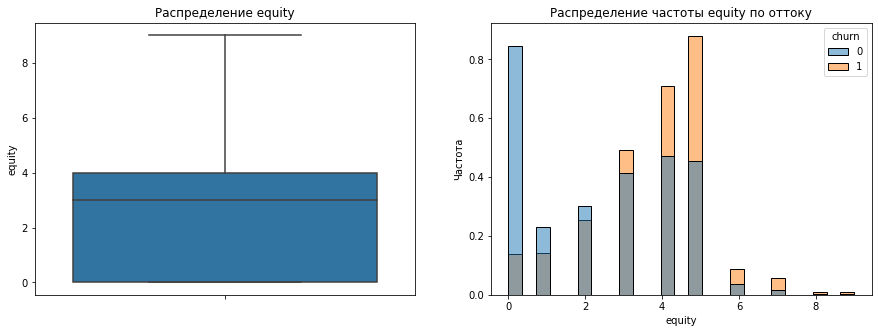

In [14]:
plot_distribution_numeric(data, 'equity')

Больше всего клиентов с 0 и 5 баллами собственности. Наибольшая отточность среди клиетов с 3-9 баллами собственности.

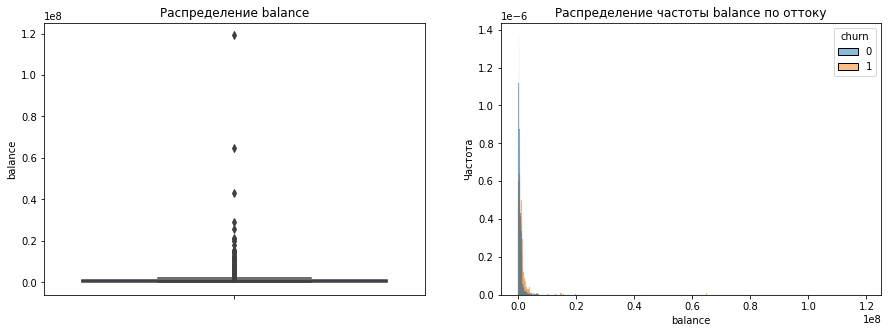

In [15]:
plot_distribution_numeric(data, 'balance')

По графикам ничего не понятно, максимальное значение примерно 120 млн. рублей, а медиана значительно ниже.

В целом у кого-то на счете может быть 120 млн. рублей, удалять не будем. Посмотрим на распределение среди людей у которых меньше 3 млн. рублей.

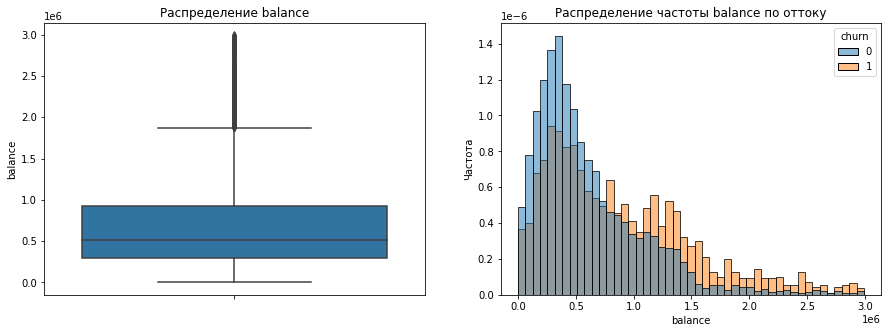

In [16]:
plot_distribution_numeric(data[data['balance'] < 3*10**6], 'balance')

Больше всего клиентов с балансом до 800 тысяч рублей. Наибольшая отточность среди клиентов у которых больше 500 тысяч на балансе.

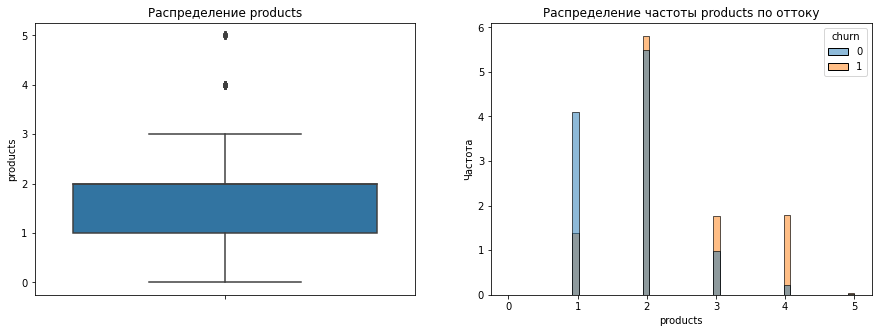

In [17]:
plot_distribution_numeric(data, 'products')

Больше всего клиентов с 1-2 продуктами. Наибольшая отточность среди клиентов у которых 2-4 продукта. Так же в данных есть клиенты с 0 продуктов, такого быть не может. Посмотрим сколько таких клиентов и удалим их.

In [18]:
print(f"Количетсов клиентов с 0 продуктов - {data[data['products'] == 0].shape[0]}")
data = data[data['products'] != 0]

Количетсов клиентов с 0 продуктов - 1


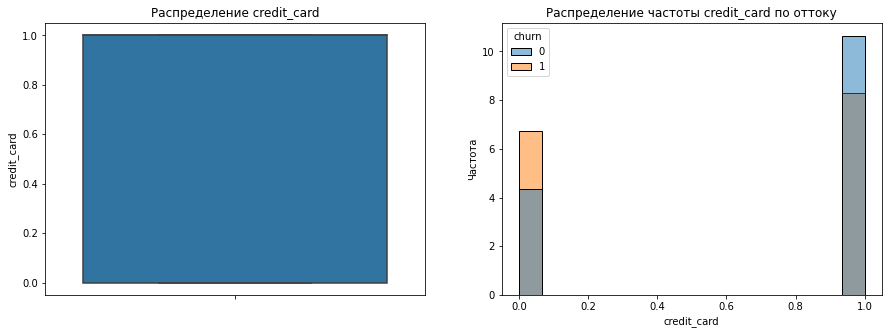

In [19]:
plot_distribution_numeric(data, 'credit_card')

Больше клиентов с кредитной картой. Наибольшая отточность среди клиентов у которых нет кредитной карты.

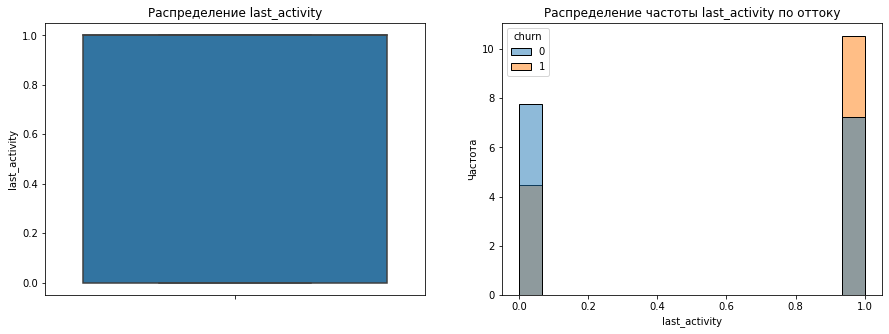

In [20]:
plot_distribution_numeric(data, 'last_activity')

Больше активных клиентов. Наибольшая отточность среди активных клиентов.

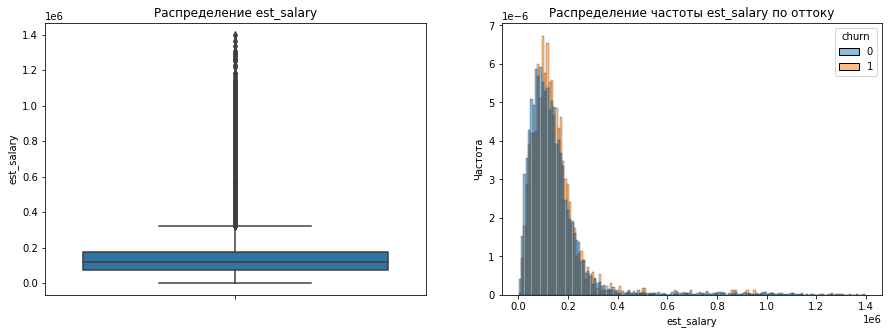

In [21]:
plot_distribution_numeric(data, 'est_salary')

Больше всего клиентов с оценочным доходом 100-200 тысяч рублей.

Построим график с оценочным доходом до 400 тысяч рублей, чтобы лучше видеть распределение частоты.

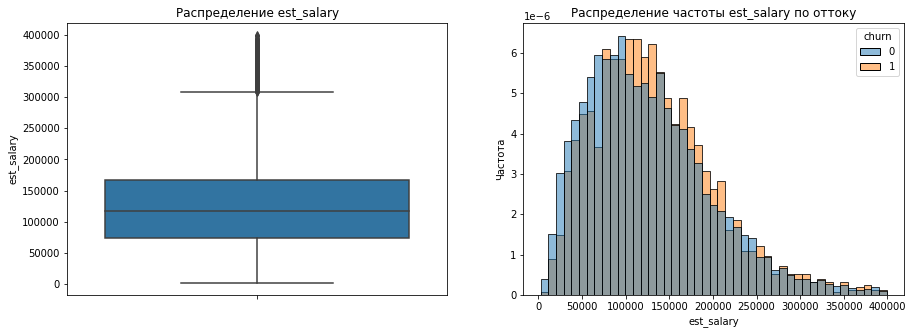

In [22]:
plot_distribution_numeric(data[data['est_salary'] <= 400*10**3], 'est_salary')

Наибольшая отточность среди клиентов с оценочным доходом 100-220 тысяч рублей.

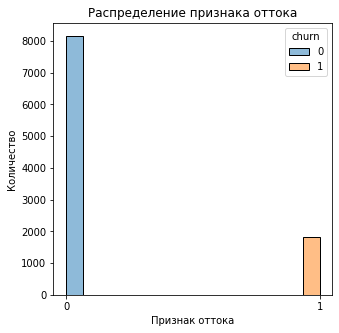

In [23]:
plt.figure(figsize=(5,5))
sns.histplot(data, x='churn', hue='churn')
plt.title('Распределение признака оттока')
plt.xlabel('Признак оттока')
plt.ylabel('Количество')
plt.xticks(range(0,2,1))
plt.show()

Больше всего клиентов которые остались.

Теперь составим портрет клиента.

Типичный клиент - это человек возрастом от 30 до 50 лет из Ярославля с 1-2 продуктами, с балансом до 800 тысяч рублей, с оценочным доходом 100-200 тысяч рублей, с кредитной картой, с 0 или 5 баллами собственности, с 800-900 баллами кредитного рейтинга и является активным клиентом.

Построим две матрицы корреляций - общую и отдельную для столбца с оттоком.

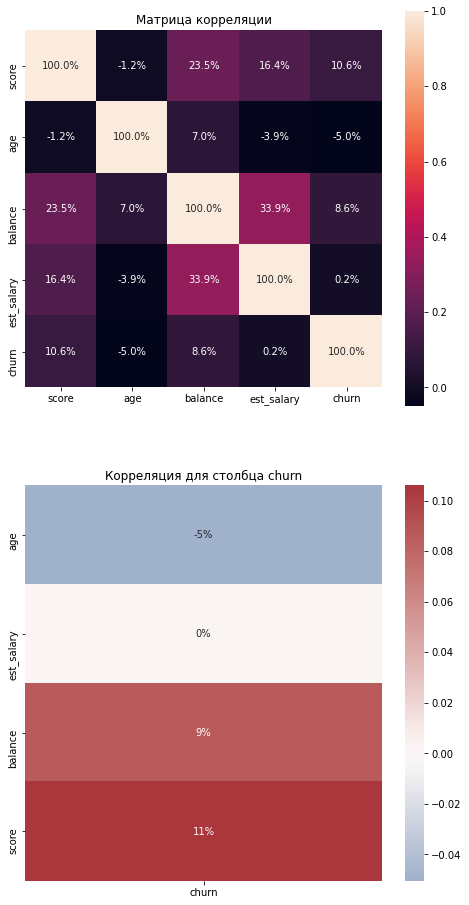

In [24]:
# Уберем userid и категориальные данные, кроме столбца churn
data_corr = data.drop(['userid', 'city', 'gender', 'equity', 'products', 'credit_card', 'last_activity'], axis=1)

plt.figure(figsize=(8,16))
ax1=plt.subplot(2,1,1)
sns.heatmap(data_corr.corr(), square=True, annot=True, fmt='.1%', ax=ax1)
plt.title('Матрица корреляции')
ax2=plt.subplot(2,1,2)
sns.heatmap(
    data_corr.corr().loc[:, ['churn']].drop('churn').sort_values('churn'), annot=True, fmt='.0%',
    cmap='vlag', center=0, ax=ax2)
plt.title('Корреляция для столбца churn')
plt.show()

Слабая корреляция между столбцами est_salary и balance. Между остальными столбцами корреляция очень слабая, либо отсутствует.

Наибольший отток клиентов:
- с 830-940 баллами кредитного рейтинга;
- у мужчин;
- у 25-35-ти летних и у 50-59-ти летних;
- с 3-9 баллами собственности;
- с более 500 тысяч на балансе;
- с 2-4 продуктами;
- без кредитной карты;
- у активных клиентов;
- с оценочным доходом 100-220 тысяч рублей.

## Сегментация клиентов

Найдем процент оттока клиентов по всем данным.

In [25]:
print(f'Процент оттока клиентов по всем данным - {round(data["churn"].mean() * 100, 2)}%')

Процент оттока клиентов по всем данным - 18.23%


Перед сегментацией клиентов проверим по одному признаку в соответствии с выводом выше. Тем самым мы проверим правильно ли сделан вывод и узнаем количество людей и долю оттока в этих группах.

Проверим клиентов с 830-940 баллами кредитного рейтинга.

In [26]:
temp = data.query("score >= 830 and score <= 940").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    5505.00
churn         0.23
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим клиентов мужского пола.

In [27]:
temp = data.query("gender == 'М'").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    4991.00
churn         0.24
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим 25-35-ти летних и у 50-59-ти летних клиентов.

In [28]:
temp = data.query("age >= 25 and age <=35 or age >= 50 and age <= 59").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    4655.00
churn         0.24
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим клиентов с 3-7 баллами собственности.

In [29]:
temp = data.query("equity >= 3 and equity <=9").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    5573.00
churn         0.26
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим клиентов с балансом от 500 тысяч.

In [30]:
temp = data.query("balance >= 500000").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    4000.0
churn         0.3
dtype: float64

Процент оттока значительно выше, чем по всем данным.

Проверим клиентов с с 2-4 продуктами.

In [31]:
temp = data.query("products >= 2 and products <= 4").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    6631.00
churn         0.24
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим клиентов без кредитной карты.

In [32]:
temp = data.query("credit_card == 0").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    3189.00
churn         0.26
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим активных клиентов.

In [33]:
temp = data.query("last_activity == 1").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    5215.00
churn         0.24
dtype: float64

Процент оттока выше, чем по всем данным.

Проверим клиентов с оценочным доходом 100-220 тысяч рублей.

In [34]:
temp = data.query("est_salary >= 100000 and est_salary <= 220000").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    4708.0
churn         0.2
dtype: float64

Процент оттока выше, чем по всем данным.

Теперь проверим сразу по 2-3 признакам так, чтобы получились группы по 500-2000 человек у которых процент оттока существенно выше, чем по всем данным. Выделим 6 групп.

In [35]:
temp = data.query("(gender == 'М') \
           and (age >= 25 and age <=35 or age >= 50 and age <= 59) \
           and (credit_card == 0)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    648.00
churn        0.44
dtype: float64

Первая группа мужчины возрастом 25-35 лет и 50-59 лет без кредитных карт. В группе 648 клиентов, процент оттока - 44%.

In [36]:
temp = data.query("(balance >= 500000) \
           and (gender == 'М') \
           and (last_activity == 1)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    1014.00
churn         0.53
dtype: float64

Вторая группа мужчины с балансом от 500 тыс. рублей, являющиеся активными клиентами. В группе 1014 клиентов, процент оттока - 53%.

In [37]:
temp = data.query("(balance >= 500000) \
           and (age >= 25 and age <=35 or age >= 50 and age <= 59)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    1782.0
churn         0.4
dtype: float64

Третья группа клиенты возрастом 25-35 лет и 50-59 лет с балансом от 500 тыс. рублей. В группе 1782 клиента, процент оттока - 40%.

In [38]:
temp = data.query("(score >= 830 and score <= 940) \
           and (last_activity == 1) \
           and (equity >= 3 and equity <=9)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    1690.00
churn         0.51
dtype: float64

Четвертая группа активные клиенты с 830-940 баллов кредитного рейтинга, с 3-7 баллами собственности. В группе 1690 клиентов, процент оттока - 51%.

In [39]:
temp = data.query("(est_salary >= 100000 and est_salary <= 220000) \
           and (score >= 830 and score <= 940) \
           and (products >= 2 and products <= 4)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    1772.00
churn         0.37
dtype: float64

Пятая группа клиенты с 830-940 баллов кредитного рейтинга, с 2-4 продуктами, с оценочным доходом 100-220 тыс. рублей. В группе 1772 клиента, процент оттока - 37%.

In [40]:
temp = data.query("(products >= 2 and products <= 4) \
           and (gender == 'М') \
           and (credit_card == 0)").agg({'userid': 'count', 'churn': 'mean'})
temp.index = ['clients', 'churn']
temp.round(2)

clients    1079.00
churn         0.41
dtype: float64

Шестая группа мужчины с 2-4 продуктами без кредитной карты. В группе 1079 клиентов, процент оттока - 41%.

Выделили 6 групп по 500-2000 человек в группе с процентом оттока 37-53%:
- Мужчины возрастом 25-35 лет и 50-59 лет без кредитных карт. В группе 648 клиентов, процент оттока - 44%;
- Мужчины с балансом от 500 тыс. рублей, являющиеся активными клиентами. В группе 1014 клиентов, процент оттока - 53%;
- Клиенты возрастом 25-35 лет и 50-59 лет с балансом от 500 тыс. рублей. В группе 1782 клиента, процент оттока - 40%;
- Активные клиенты с 830-940 баллов кредитного рейтинга, с 3-7 баллами собственности. В группе 1690 клиент, процент оттока - 51%;
- Клиенты с 830-940 баллов кредитного рейтинга, с 2-4 продуктами, с оценочным доходом 100-220 тыс. рублей. В группе 1772 клиента, процент оттока - 37%;
- Мужчины с 2-4 продуктами без кредитной карты. В группе 1079 клиентов, процент оттока - 41%.

## Проверка гипотез

Проверим две статистических гипотезы:
- о различии дохода между клиентами, которые ушли и которые остались.
- о различии количества продуктов между клиентами, которые ушли и которые остались.

Для проверки первой гипотезы будем использовать тест Манна-Уитни потому, что метрика численная, есть сильные выбросы в обоих группах, которые не получится исключить без потери ценной информации.

Для проверки второй гипотезы будем использовать т-тест потому, что метрика численная и сильных выбросов нет. Будем использовать метод st.ttest_ind для независимых выборок.

Нулевая гипотеза - доход клиентов, которые ушли и клиентов, которые остались одинаковый. Альтернативная гипотеза - доход клиентов, которые ушли и клиентов, которые остались разный.

In [41]:
data.groupby('churn')['est_salary'].describe()[['mean', '50%']].round(1)

,mean,50%
churn,,
0,147674.6,118227.6
1,148357.5,125408.9


In [42]:
alpha = 0.05
results = st.mannwhitneyu(data.loc[data['churn'] == 0, 'est_salary'], data.loc[data['churn'] == 1, 'est_salary'])
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу в пользу альтернативной


pvalue меньше уровня статистической значимости. Отвергаем нулевую гипотезу в пользу альтернативной.

Нулевая гипотеза - количество продуктов клиентов, которые ушли и клиентов которые остались одинаковое. Альтернативная гипотеза - количество продуктов клиентов, которые ушли и клиентов, которые остались разное.

In [43]:
data.groupby('churn')['products'].describe()['mean'].reset_index().round(2)

,churn,mean
0,0,1.76
1,1,2.38


In [44]:
alpha = 0.05
results = st.ttest_ind(data.loc[data['churn'] == 0, 'products'], data.loc[data['churn'] == 1, 'products'])
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение:  2.5178746542447946e-208
Отвергаем нулевую гипотезу в пользу альтернативной


pvalue меньше уровня статистической значимости. Отвергаем нулевую гипотезу в пользу альтернативной.

Проверили две статистические гипотезы. Обе отвергли в пользу альтернативных гипотез.

- Альтернативаня гипотеза 1 - доход клиентов, которые ушли и клиентов, которые остались разный;
- Альтернативная гипотеза 2 - количество продуктов клиентов, которые ушли и клиентов, которые остались разное.

##  Вывод

Вывод: 
- Типичный клиент - это человек возрастом от 30 до 50 лет из Ярославля с 1-2 продуктами, с балансом до 800 тысяч рублей, с оценочным доходом 100-200 тысяч рублей, с кредитной картой, с 0 или 5 баллами собственности, с 800-900 баллами кредитного рейтинга и является активным клиентом;
- Наибольший отток клиентов:
    - с 830-940 баллами кредитного рейтинга;
    - у мужчин;
    - у 25-35-ти летних и у 50-59-ти летних;
    - с 3-9 баллами собственности;
    - с более 500 тысяч на балансе;
    - с 2-4 продуктами;
    - без кредитной карты;
    - у активных клиентов;
    - с оценочным доходом 100-220 тысяч рублей.
- Процент оттока клиентов по всем данным - 18.23%;
- Группы клиентов по 500-2000 человек в группе с процентом оттока существенно выше, чем по всем данным:
    - Мужчины возрастом 25-35 лет и 50-59 лет без кредитных карт. В группе 648 клиентов, процент оттока - 44%;
    - Мужчины с балансом от 500 тыс. рублей, являющиеся активными клиентами. В группе 1014 клиентов, процент оттока - 53%;
    - Клиенты возрастом 25-35 лет и 50-59 лет с балансом от 500 тыс. рублей. В группе 1782 клиента, процент оттока - 40%;
    - Активные клиенты с 830-940 баллов кредитного рейтинга, с 3-7 баллами собственности. В группе 1690 клиент, процент оттока - 51%;
    - Клиенты с 830-940 баллов кредитного рейтинга, с 2-4 продуктами, с оценочным доходом 100-220 тыс. рублей. В группе 1772 клиента, процент оттока - 37%;
    - Мужчины с 2-4 продуктами без кредитной карты. В группе 1079 клиентов, процент оттока - 41%.
- Доход клиентов, которые ушли и клиентов, которые остались разный;
- Количество продуктов клиентов, которые ушли и клиентов, которые остались разное.

Для уменьшения оттока рекомендуется:
- Узнать причины столь высокого оттока в выделенных группах и устранить их;
- Активнее предлагать клиентам кредитные карты банка.

Презентация - https://disk.yandex.ru/i/YcSz60vYY7E_tw